# Tutorial for vaex as a library
## Introduction
This tutorial shortly introduces how to use vaex from IPython notebook. This tutorial assumes you have vaex installed as a library, you can run `python -c 'import vaex'` to check this.
This document although not a IPython notebook, is generated from a notebook, and you should be able to reproduce all examples.

## Run IPython notebook
From the <a href='http://ipython.org/notebook.html'>IPython notebook website:</a>
> The IPython Notebook is an interactive computational environment, in which you can combine code execution, rich text, mathematics, plots and rich media

To start it, run `$ ipython notebook` in your shell, and it should automatically open the main webpage. Start a new notebook by clicking `new`.

## Starting
Start you notebook by importing the relevant packages, for this tutorial, we will be using vaex itself, <a href="www.nupmy.org">numpy</a> and <a href="matplotlib.org">matplotlib</a> for plotting. We also configure matplotib to show the plots in the notebook itself

In [1]:
import vaex as vx
import numpy as np
import matplotlib.pylab as plt # simpler interface for matplotlib
# next line configures matplotlib to show the plots in the notebook, other option is qt to open a dialog
%matplotlib inline

## Open a dataset
To open a dataset, we can call vx.open to open local files. See the documentation of [vaex.open](api.html#vaex.open) for the arguments, hit shift-tab (1 or 2 times) or run `vx.open?` in the notebook for direct help. For this tutorial we use `vx.example()` which opens a dataset provided with vaex. (_Note that ds is short for dataset_)

In [2]:
ds = vx.example()
# ds = vx.open('yourfile.hdf5') # in case you want to load a different dataset

You can get information about the dataset, such as the columns by simply typing `ds` as the last command in a cell.

In [3]:
ds

x,float64
y,float64
z,float64
vx,float64
vy,float64
vz,float64
E,float64
FeH,float64
L,float64
Lz,float64
random_index,int64


To get a list with all column names, use Dataset's [get_column_names](api.html#vaex.dataset.Dataset.get_column_names) method. Note that tab completion should work, typing `ds.get_c` and then pressing tab should help your complete it.


In [4]:
ds.get_column_names()

['x', 'y', 'z', 'vx', 'vy', 'vz', 'E', 'FeH', 'L', 'Lz', 'random_index']

## Calculating statistics
Vaex can calculate statistics for colums, but also for an expression build from columns.

In [5]:
ds.mean("x"), ds.std("x"), ds.correlation("vx**2+vy**2+vz**2", "E")

(-0.067131491264005971, 7.3174597654824751, array(0.00676355917633636))

Since columns names can sometimes be difficult to remember, and to take advantage of the autocomplete features of the Notebook, column names can be accessed using the .col property, for instance

In [6]:
print(ds.col.x)

x


In [7]:
ds.mean(ds.col.x)

-0.067131491264005971

Dataset contains many methods to compute statistics, and plotting routines, see the API documentation for more details, for instance for:

* [Dataset.count](api.html#vaex.dataset.Dataset.count)
* [Dataset.mean](api.html#vaex.dataset.Dataset.mean)
* [Dataset.std](api.html#vaex.dataset.Dataset.std)
* [Dataset.var](api.html#vaex.dataset.Dataset.var)
* [Dataset.median](api.html#vaex.dataset.Dataset.median)
* [Dataset.percentile](api.html#vaex.dataset.Dataset.percentile)
* [Dataset.mode](api.html#vaex.dataset.Dataset.median)
* [Dataset.min](api.html#vaex.dataset.Dataset.min)
* [Dataset.max](api.html#vaex.dataset.Dataset.max)
* [Dataset.minmax](api.html#vaex.dataset.Dataset.minmax)
* [Dataset.mutual_information](api.html#vaex.dataset.Dataset.mutual_information)
* [Dataset.correlation](api.html#vaex.dataset.Dataset.correlation)
* [Dataset.histogram](api.html#vaex.dataset.Dataset.histogram)
* [Dataset.plot](api.html#vaex.dataset.Dataset.plot)
* [Dataset.plot_bq](api.html#vaex.dataset.Dataset.plot_bq)
* [Dataset.plot1d](api.html#vaex.dataset.Dataset.plot1d)

Most of the statistics can also be calculated on a grid, which can also be visualized using for instance matplotlib.

In [8]:
ds.mean("E", binby=["x", "y"], shape=(2,2), limits=[[-10,10], [-10, 10]])

array([[-119166.43858099, -118291.18402363],
       [-117650.31604966, -119542.86139539]])

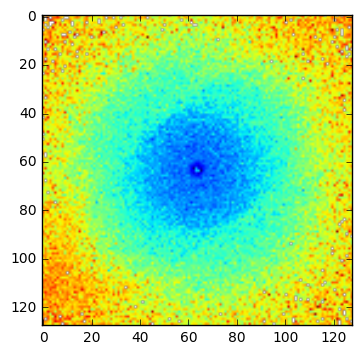

In [9]:
mean_energy = ds.mean("E", binby=["x", "y"], shape=(128,128), limits=[[-10,10], [-10, 10]])
plt.imshow(mean_energy)

## Plotting
Instead of using "bare" matplotlib to plot, using the .plot method is more convenient. It sets axes limits, labels (with units when known), and adds a colorbar. Learn more using the docstring, by typing `ds.plot?` or using shift-tab, or opening [Dataset.plot](api.html#vaex.dataset.Dataset).

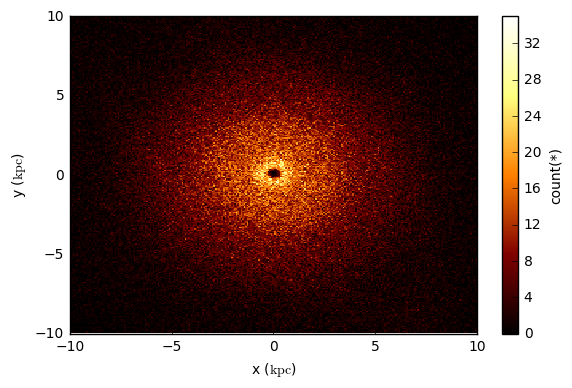

In [10]:
ds.plot("x", "y", limits=[[-10,10], [-10, 10]]);

Instead of plotting the counts, the mean of an expression can be plotted. (Other options are sum, std, var, correlation, covar, min, max) 

/Users/maartenbreddels/anaconda3/envs/vaex-forge2/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


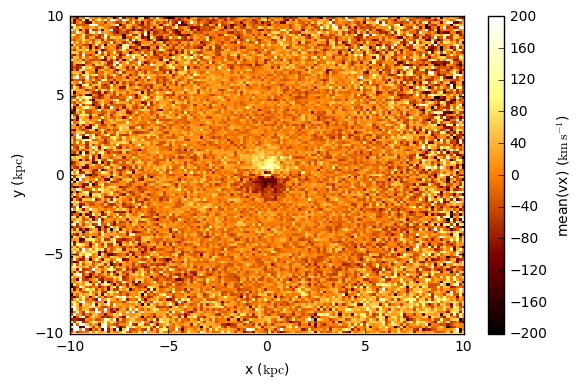

In [11]:
ds.plot("x", "y", what="mean(vx)", limits=[[-10,10], [-10, 10]], vmin=-200, vmax=200, shape=128);

More panels can be plotting giving a list of pairs of expressions as the first argument (which we call a subspace).

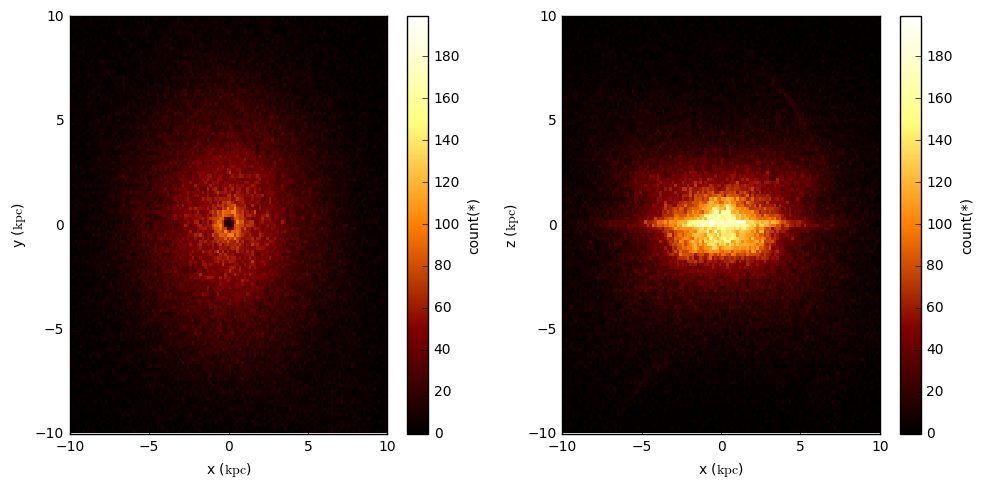

In [12]:
ds.plot([["x", "y"], ["x", "z"]], limits=[[-10, 10], [-10, 10]], figsize=(10,5), shape=128);

And the same can be done for the `what` argument. Note that the f argument is the transformation that will be applied to the values, for instance "log", "log10", "abs", or None when doing no transformation. If given as a single argument, if will apply to all plots, otherwise it should be a list of the same length as the what argument.

/Users/maartenbreddels/anaconda3/envs/vaex-forge2/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


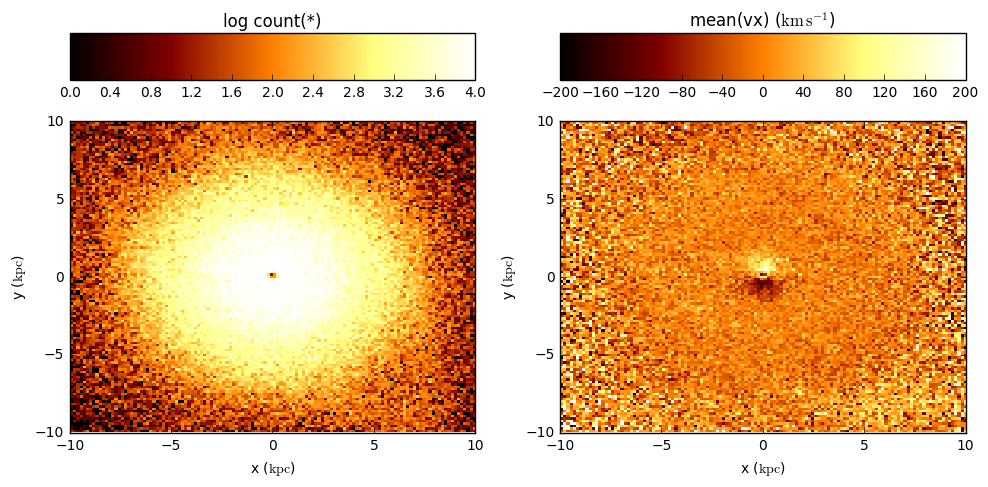

In [13]:
ds.plot("x", "y", what=["count(*)", "mean(vx)"], f=["log", None],
        limits=[[-10, 10], [-10, 10]], figsize=(10,5), shape=128, vmin=[0, -200], vmax=[4, 200]);

When they are combined, `what` will form the columns of a subplot, while the rows are the different subspaces.

/Users/maartenbreddels/anaconda3/envs/vaex-forge2/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


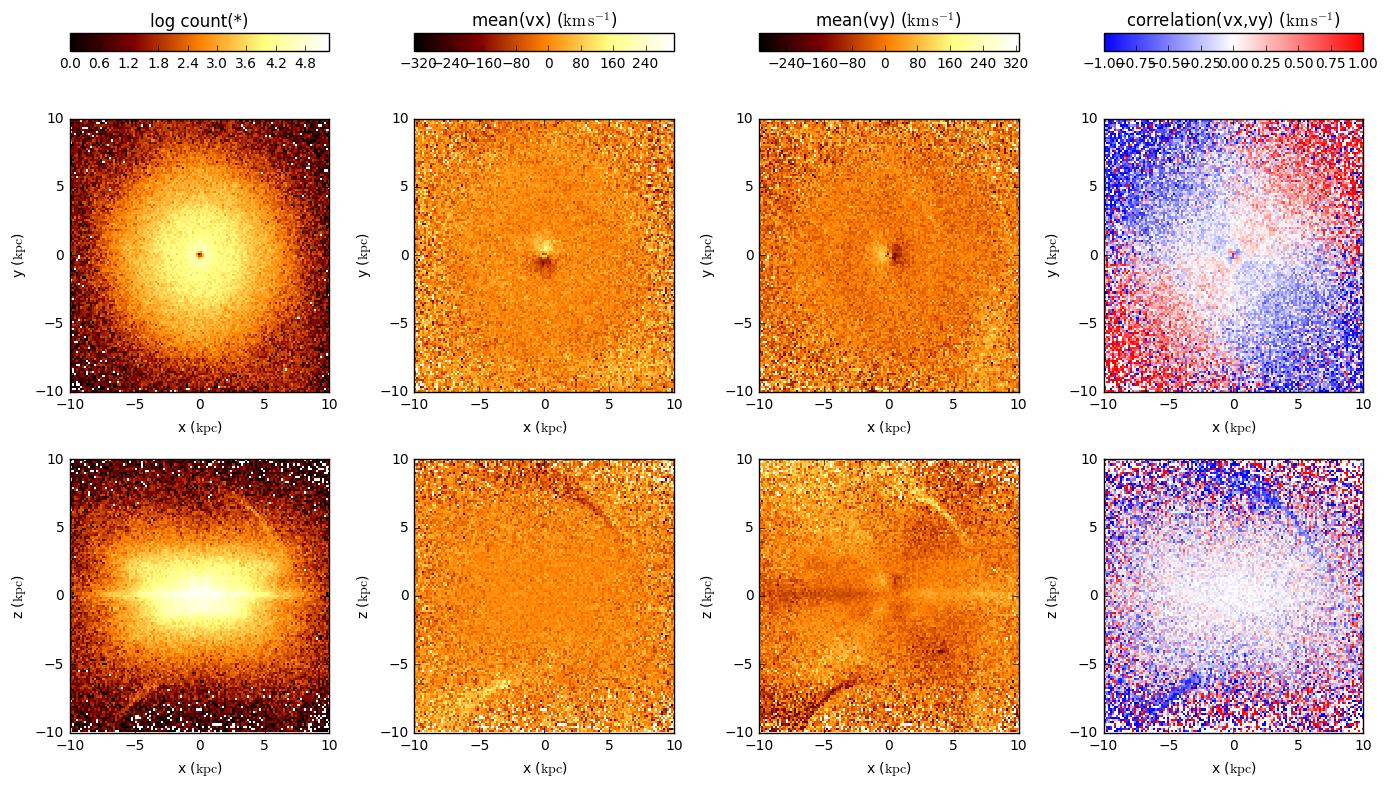

In [14]:
ds.plot([["x", "y"], ["x", "z"]],  f=["log", None, None, None],
        what=["count(*)", "mean(vx)", "mean(vy)", "correlation(vx,vy)"],
        colormap=["afmhot", "afmhot", "afmhot", "bwr"],
        limits=[[-10, 10], [-10, 10]], figsize=(14,8), shape=128);

## Selections
For working with a part of the data, we use what we call selections. When a selection is applied to a dataset, it keeps a boolean in memory for each row indicating it is selected or not. All statistical methods take a selection argument, which can be `None` or `False` for no selection, `True` or `"default"` for the default selection, or a string refering to the selection (corresponding to the name argument of the [Dataset.select](api.html#vaex.dataset.Dataset) method). It is also possible to have expressions in a selection, but these selections will not be cached and computed every time when needed.

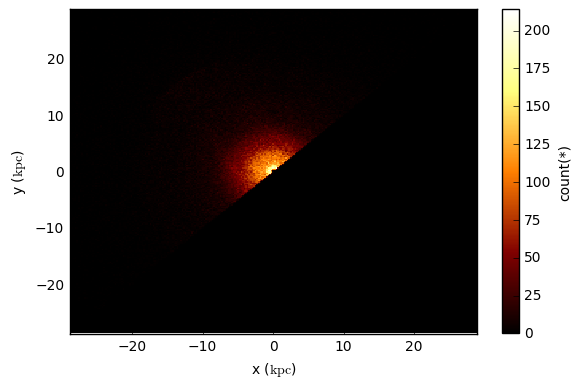

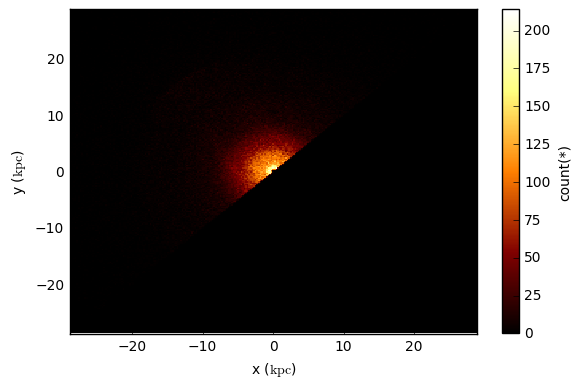

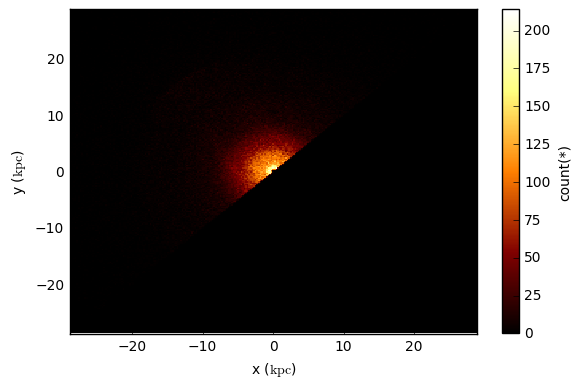

In [15]:
# the following plots are all identical
ds.select("y > x")
ds.plot("x", "y", selection=True, show=True)
ds.plot("x", "y", selection="default", show=True) # same as the previous
ds.plot("x", "y", selection="y > x", show=True); # similar, but selection will be recomputed every time


Multiple selections can be overplotted, where `None` means no selection, and `True` is an alias for the default selection name of "default". The selections will be overplotted where the background will be `faded`.  (Note that becase the log is taken of zero, this results in NaN, which is shown as transparent pixels.)

/Users/maartenbreddels/anaconda3/envs/vaex-forge2/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)
/Users/maartenbreddels/vaex/src/vaex/vaex/image.py:96: RuntimeWarning: invalid value encountered in true_divide
  result = ((1.-aB) * aA * xA  + (1.-aA) * aB * xB + aA * aB * f) / aR
/Users/maartenbreddels/vaex/src/vaex/vaex/image.py:99: RuntimeWarning: invalid value encountered in true_divide
  result = (np.minimum(aA, 1-aB)*xA + aB*xB)/aR


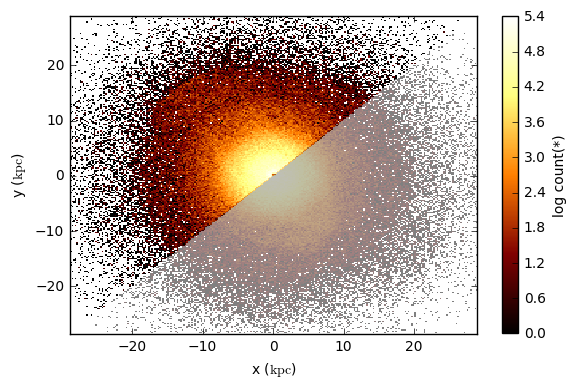

In [16]:
ds.plot("x", "y", selection=[None, True], f="log");

Selection can be made more complicated, or can be logically combined using a boolean operator. The default is to replace the current selections, other possiblities are: "replace", "and", "or", "xor", "subtract"

/Users/maartenbreddels/anaconda3/envs/vaex-forge2/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)
/Users/maartenbreddels/vaex/src/vaex/vaex/image.py:96: RuntimeWarning: invalid value encountered in true_divide
  result = ((1.-aB) * aA * xA  + (1.-aA) * aB * xB + aA * aB * f) / aR
/Users/maartenbreddels/vaex/src/vaex/vaex/image.py:99: RuntimeWarning: invalid value encountered in true_divide
  result = (np.minimum(aA, 1-aB)*xA + aB*xB)/aR


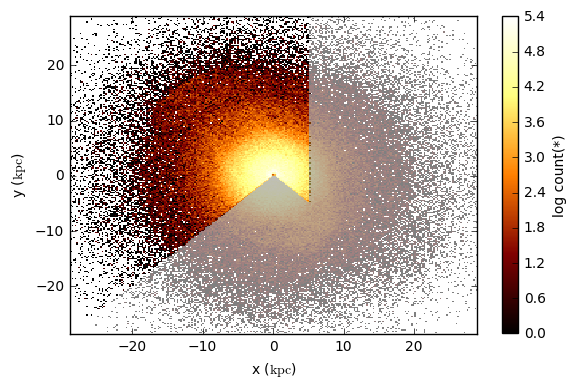

In [17]:
ds.select("y > x")
ds.select("y > -x", mode="or")
# this next line has the same effect as the above two
# dataset.select("(y > x) | (x > -y)")
# |,& and ^ are used for 'or' 'and', and 'xor'
ds.select("x > 5", mode="subtract")
ds.plot("x", "y", selection=[None, True], f="log");

Using the visual argument, it is possible to show the selections as columns instead, see [Dataset.plot](api.html#vaex.dataset.Dataset.plot) for more details.

/Users/maartenbreddels/anaconda3/envs/vaex-forge2/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


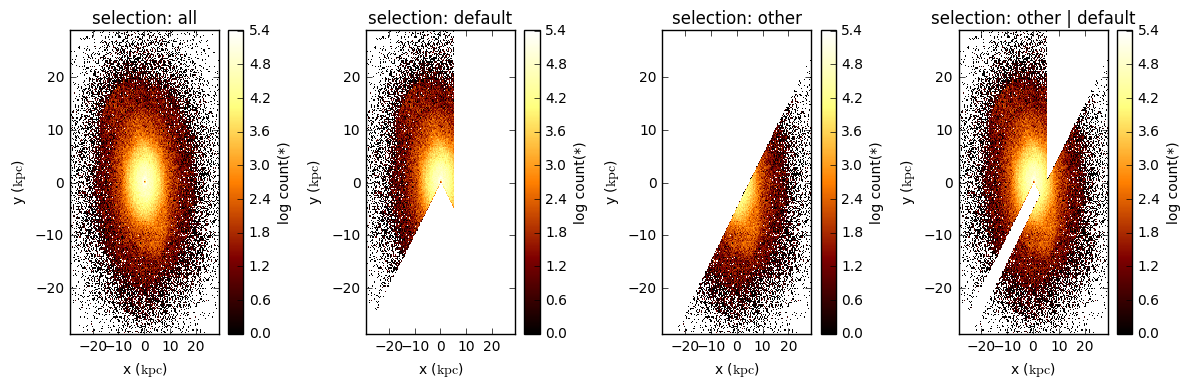

In [18]:
ds.select("x - 5> y", name="other")
ds.plot("x", "y", selection=[None, True, "other", "other | default"],
        f="log", visual=dict(column="selection"), figsize=(12,4));

Besides making plots, statisics can also be computed for selections

In [19]:
ds.max("x", selection=True)

array(4.99998713)

In [20]:
ds.max("x", selection=[None, True])

array([ 271.365997  ,    4.99998713])

In [21]:
ds.max(["x", "y"], selection=[None, True])

array([[ 271.365997  ,    4.99998713],
       [ 146.465836  ,  146.465836  ]])

In [22]:
ds.mean(["x", "y"], selection=[None, True, "other", "x > y"])

array([[-0.06713149, -2.98854513,  5.90555941,  3.59256693],
       [-0.05358987,  2.99097581, -6.92724312, -4.19886827]])

## Virtual columns
If a particular expression occurs often, it may be convenient to create a virtual column, it behaves exactly like a normal column, but it is calculated on the fly (without taking up the memory of a full column, since it is done is chunks).

/Users/maartenbreddels/anaconda3/envs/vaex-forge2/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


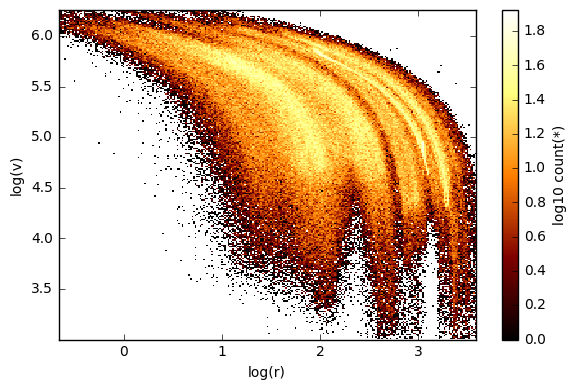

In [23]:
ds.add_virtual_column("r", "sqrt(x**2+y**2+z**2)")
ds.add_virtual_column("v", "sqrt(vx**2+vy**2+vz**2)")
ds.plot("log(r)", "log(v)", f="log10");

Extra methods for creating common virtual columns are:

 * [add_virtual_column](api.html#vaex.dataset.Dataset.add_virtual_column)
 * [add_virtual_column_bearing](api.html#vaex.dataset.Dataset.add_virtual_column_bearing)
 * [add_virtual_columns_aitoff](api.html#vaex.dataset.Dataset.add_virtual_columns_aitoff)
 * [add_virtual_columns_cartesian_to_spherical](api.html#vaex.dataset.Dataset.add_virtual_columns_cartesian_to_spherical)
 * [add_virtual_columns_celestial](api.html#vaex.dataset.Dataset.add_virtual_columns_celestial)
 * [add_virtual_columns_eq2ecl](api.html#vaex.dataset.Dataset.add_virtual_columns_eq2ecl)
 * [add_virtual_columns_eq2gal](api.html#vaex.dataset.Dataset.add_virtual_columns_eq2gal)
 * [add_virtual_columns_equatorial_to_galactic_cartesian](api.html#vaex.dataset.Dataset.add_virtual_columns_equatorial_to_galactic_cartesian)
 * [add_virtual_columns_lbrvr_proper_motion2vcartesian](api.html#vaex.dataset.Dataset.add_virtual_columns_lbrvr_proper_motion2vcartesian)
 * [add_virtual_columns_matrix3d](api.html#vaex.dataset.Dataset.add_virtual_columns_matrix3d)
 * [add_virtual_columns_proper_motion_eq2gal](api.html#vaex.dataset.Dataset.add_virtual_columns_proper_motion_eq2gal)
 * [add_virtual_columns_rotation](api.html#vaex.dataset.Dataset.add_virtual_columns_rotation)
 * [add_virtual_columns_spherical_to_cartesian](api.html#vaex.dataset.Dataset.add_virtual_columns_spherical_to_cartesian)
 
Don't fear to look at the source (click the green link [source]).
 

## More about the dataset
Vaex works best with hdf5 and fits files, but can import from other sources as well. File formats are recognized by the extension. For .vot a VOTable is assumed, and astropy is used for reading this. For .asc the astropy's ascii reader is used. However, these formats require the dataset to fit into memory, and exporting them in hdf5 or fits format may lead to better performance and faster read times. Datasets can also be made from numpy arrays using [vaex.from_arrays](api.html#vaex.from_arrays), or imported for convenience from pandas using [vaex.from_pandas](api.html#vaex.from_pandas). 

In the next example we create a dataset from arrays, and export it to disk.

In [24]:
# Create a 6d gaussian clump
q = np.random.normal(10, 2, (6, 10000))
dataset_clump_arrays = vx.from_arrays(x=q[0], y=q[1], z=q[2], vx=q[3], vy=q[4], vz=q[5])
dataset_clump_arrays.add_virtual_column("r", "sqrt(x**2+y**2+z**2)")
dataset_clump_arrays.add_virtual_column("v", "sqrt(vx**2+vy**2+vz**2)")

# create a temporary file
import tempfile
filename = tempfile.mktemp(suffix=".hdf5")

# when exporting takes long, progress=True will give a progress bar
# here, we don't want to export virtual columns, which is the default
dataset_clump_arrays.export_hdf5(filename, progress=True, virtual=False)
print("Exported to: %s" % filename)

Exported to: /var/folders/vn/_rmzj8jd0215_g9yfrn8pmgm0000gn/T/tmps5efbvfh.hdf5


exporting: 100% |####################################################################################################################################| Time: 0:00:00 CPU Usage:     0%


In [25]:
ds_clump = vx.open(filename)
print("Columns: %r" % ds_clump.get_column_names())

Columns: ['x', 'y', 'z', 'vx', 'vy', 'vz']


### concatenating tables
Using the .concat method, datasets can be concatenated to form one big dataset (without copying the data).

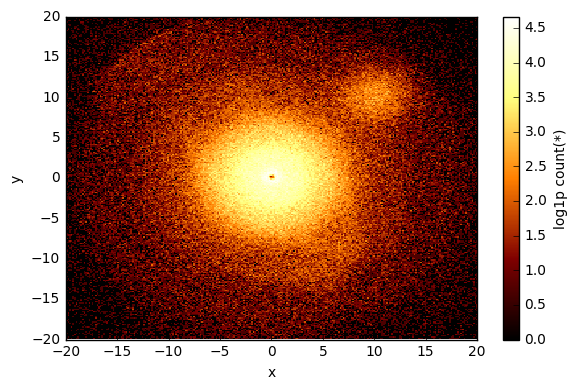

In [26]:
ds2 = ds.concat(ds_clump)
ds2.plot("x", "y", f="log1p", limits=[[-20, 20], [-20, 20]]);

### Shuffling
TODO

## Efficient use of multiple calculations
Imaging you want to calcule the correlation coefficient for a few subspaces. First we calculate it for E and Lz.

In [27]:
ds.correlation("E", "Lz")

array(-0.09404020895356191)

In the process, all the data for the column E and Lz was processed, if we now calculate the correlation coefficient for E and L, we go over the data for column E again. Especially if the data does not fit into memory, this is quiet inefficient.

In [28]:
ds.correlation("E", "L")

array(0.6890619164898808)

If instead, we call the correlation method with a list of subspaces, there is only one pass over the data, which can me much more efficient.

In [29]:
ds.correlation([["E", "Lz"], ["E", "L"]])

array([-0.09404021,  0.68906192])

Especially if many subspaces are used, as in the following example.

In [30]:
subspaces = ds.combinations()
correlations = ds.correlation(subspaces)
mutual_informations = ds.mutual_information(subspaces)

In [31]:
from astropy.io import ascii
import sys
names = ["_".join(subspace) for subspace in subspaces]
ascii.write([names, correlations, mutual_informations], sys.stdout,
            names=["names", "correlation", "mutual_information"])
# replace sys.stdout by a filename such as "example.asc"
filename_asc = tempfile.mktemp(suffix=".asc")
ascii.write([names, correlations, mutual_informations], filename_asc,
            names=["names", "correlation", "mutual_information"])

print("--------")
# or write it as a latex table
ascii.write([names, correlations, mutual_informations],
            sys.stdout, names=["names", "correlation", "mutual information"], Writer=ascii.Latex)


names correlation mutual_information
x_y -0.066913086088751 0.1511814526380327
x_z -0.026563129089248065 0.18439180585071951
x_vx -0.0077917898183534 0.10435586691547903
x_vy 0.0001401879823959935 0.15943598551987362
x_vz 0.020449779578494472 0.10991350641870239
x_E -0.012435764665535712 0.37575458684670193
x_FeH 0.005261856198512363 0.1249204442224574
x_L -0.02566286245858961 0.19727462018198172
x_Lz -0.00030294055309957344 0.2150162106163776
x_random_index 0.002157476491340153 0.32861028043895546
y_z 0.030838572698652564 0.21418760688854802
y_vx 0.01804910998078914 0.17013399253827877
y_vy -0.004114980900371909 0.1097919284981679
y_vz -0.028477638600608927 0.11538952339280187
y_E -0.006099113309545572 0.43174233264307804
y_FeH 0.015003295277717208 0.13276137709114438
y_L -0.00838158892350927 0.21606618030384148
y_Lz 0.027260049760350104 0.23708979843321443
y_random_index -0.002740986556550819 0.36853287435535315
z_vx -0.021753308878140573 0.11626543575085833
z_vy 0.029883551266368533

In [32]:
# reading it back in
table = ascii.read(filename_asc)
print("this is an astropy table:\n", table)
correlations = table["correlation"]
print
print("this is an astropy column:\n", correlations)
print
print("this is the numpy data:\n", correlations.data)
# short: table["correlation"].data

this is an astropy table:
      names          correlation    mutual_information
---------------- ----------------- ------------------
             x_y  -0.0669130860888     0.151181452638
             x_z  -0.0265631290892     0.184391805851
            x_vx -0.00779178981835     0.104355866915
            x_vy 0.000140187982396      0.15943598552
            x_vz   0.0204497795785     0.109913506419
             x_E  -0.0124357646655     0.375754586847
           x_FeH  0.00526185619851     0.124920444222
             x_L  -0.0256628624586     0.197274620182
            x_Lz  -0.0003029405531     0.215016210616
  x_random_index  0.00215747649134     0.328610280439
             ...               ...                ...
 vz_random_index  -0.0113217621778     0.184835199196
           E_FeH  -0.0140682230539     0.454241867922
             E_L     0.68906191649     0.740406133788
            E_Lz  -0.0940402089536      1.07067379295
  E_random_index   -0.129443880426      1.71328535326
 

## Where to go from here?
Continue reading on:

 * [Advanced plotting](advanced_plotting.html)

This tutorial covers the basics, more can be learned by reading the [API documentation](api.html). But note that every docstring can be read from the notebook using shift-tab, or using for instance `ds.plot?`.

If you think a particular topic should be addressed here, please [open an issue at github](https://github.com/maartenbreddels/vaex/issues)